In [1]:
'''
Paper we are implementing: 
Analysis of Deep Complex-Valued Convolutional Neural Networks for MRI Reconstruction
https://arxiv.org/pdf/2004.01738

Dataset:
FastMRI Single Coil Knee Dataset
https://fastmri.med.nyu.edu
'''

import h5py
import numpy as np
import os
import torch

def load_h5_file(filepath: str):
    '''Load an HDF5 file and return its contents as a dictionary.'''
    with h5py.File(filepath, 'r') as f_read:
        ds = dict()
        ds['kspace'] = torch.tensor(f_read['kspace'][()])
    return ds

def ifft2c(kspace: torch.Tensor):
    '''2D centered inverse FFT for reconstructing images from k-space data.'''
    return torch.fft.ifftshift(
        torch.fft.ifft2(
            torch.fft.fftshift(kspace, dim=(-2, -1)), norm='ortho'
        ),
        dim=(-2, -1)
    )

In [2]:
'''
MASKING FUNCTIONS
'''

def mask_1d_equispaced(N: int, accel: int = 4, acs: int = 24, offset: int = 0):
    '''
    N: length along the masked axis (e.g., 640 or 368)
    accel: target acceleration (e.g., 4 => ~25% lines kept)
    acs: contiguous fully-sampled center size
    offset: phase for the stride pattern (0..accel-1)
    '''
    mask = torch.zeros(N, dtype=torch.bool)
    # center ACS
    c0 = (N - acs) // 2
    mask[c0:c0+acs] = True
    # equispaced outside ACS
    for i in range(N):
        if i < c0 or i >= c0+acs:
            if ((i - offset) % accel) == 0:
                mask[i] = True
    return mask


class EquispacedMasker:
    '''
    Equispaced 1D mask with center ACS region.
    '''
    def __init__(self, accel: int = 4, acs: int = 24, offset: int = 0):
        self.accel = accel
        self.acs = acs
        self.offset = offset

    def __call__(self, N: int):
        return mask_1d_equispaced(N, self.accel, self.acs, self.offset)

In [3]:
from torch.utils.data import Dataset
import torchvision

class SingleCoilDataset(Dataset):
    '''
    Single-coil MRI dataset loader for HDF5 files. Applies a mask function to the k-space data.
    A data sample is a full reconstruction from the k-space data before masking and one after masking.
    '''
    def __init__(self, folder_path, mask_func=EquispacedMasker()):
        '''
        folder_path: path to the folder containing HDF5 files
        mask_func: function that generates a mask given the size of the k-space data
        '''
        self.filepaths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.h5')]
        self.mask_func = mask_func

        # Build file-slice index so that each __getitem__ call loads only one slice
        filepath_slice_idxs = []
        for filepath in self.filepaths:
            ds = load_h5_file(filepath)
            # Assuming ds['kspace'] shape is (num_slices, height, width)
            n_slices = ds['kspace'].shape[-3]
            for slice_idx in range(n_slices):
                filepath_slice_idxs.append((filepath, slice_idx))
        self.filepath_slice_idxs = filepath_slice_idxs

        # Since some images have different widths, we will need to center crop to the smallest width
        self.crop = torchvision.transforms.CenterCrop((640, 320))

    
    def __len__(self):
        return len(self.filepath_slice_idxs)
    
    def __getitem__(self, idx):
        filepath, slice_idx = self.filepath_slice_idxs[idx]
        ds = load_h5_file(filepath)
        kspace = ds['kspace'][slice_idx, :, :]
        mask = self.mask_func(kspace.shape[-1]) # assuming masking along the last dimension
        masked_kspace = kspace * mask
        image_full = ifft2c(kspace)
        image_masked = ifft2c(masked_kspace)
        image_masked, image_fulle = image_masked.unsqueeze(0), image_full.unsqueeze(0) # add channel dim

        # Apply center crop
        image_masked = self.crop(image_masked)
        image_full = self.crop(image_full)

        return image_masked, image_full

In [4]:
'''
MODEL MODULE DEFINITIONS
'''

import torch.nn as nn

class ComplexConv2d(nn.Module):
    '''
    2d Complex Convolution Layer
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None):
        super().__init__()
        self.conv_real = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode, device=device, dtype=dtype)
        self.conv_imag = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode, device=device, dtype=dtype)
    def forward(self, X):
        real_part = self.conv_real(X.real) - self.conv_imag(X.imag)
        imag_part = self.conv_real(X.real) + self.conv_imag(X.imag)
        return real_part + 1j * imag_part
    
class ComplexConvTranspose2d(nn.Module):
    '''
    2d Complex Transposed Convolution Layer
    '''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None):
        super().__init__()
        self.tconv_real = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode, device=device, dtype=dtype)
        self.tconv_imag = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias, padding_mode=padding_mode, device=device, dtype=dtype)
    def forward(self, X):
        real_part = self.tconv_real(X.real) - self.tconv_imag(X.imag)
        imag_part = self.tconv_real(X.real) + self.tconv_imag(X.imag)
        return real_part + 1j * imag_part

class CReLU(nn.Module):
    '''
    CReLu Activation Function
    '''
    def __init__(self):
        super().__init__()
        self.ReLU = nn.ReLU()
    def forward(self, X):
        return self.ReLU(X.real) + 1j * self.ReLU(X.imag)
    

'''
A COUPLE DIFFERENT POOLING OPTIONS WORTH EXPLORING
'''
class ComplexAvgPool2d(nn.Module):
    '''
    2d Complex Average Pooling Layer
    '''
    def __init__(self, kernel_size, stride=None, padding=0, ceil_mode=False, count_include_pad=True, divisor_override=None):
        super().__init__()
        self.pool = nn.AvgPool2d(kernel_size, stride=stride, padding=padding, ceil_mode=ceil_mode, count_include_pad=count_include_pad, divisor_override=divisor_override)
    def forward(self, X):
        real_part = self.pool(X.real)
        imag_part = self.pool(X.imag)
        return real_part + 1j * imag_part
    
class ComplexMaxMagPool2d(nn.Module):
    '''
    2d Complex Max Pooling Useing Magnitude
    '''
    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size, stride=stride, padding=padding, dilation=dilation, return_indices=True, ceil_mode=False)
        self.return_indices = return_indices # To preserve expected functionality
    def forward(self, X):
        pass #TODO: Implement this pooling method based on magnitude
        
class ComplexMaxCompPool2d(nn.Module):
    '''
    2d Complex Max Pooling Useing Individual Components
    '''
    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size, stride=stride, padding=padding, dilation=dilation, ceil_mode=False)
    def forward(self, X):
        # Apply max pooling based on magnitude
        real_part = self.pool(X.real)
        imag_part = self.pool(X.imag)
        return real_part + 1j * imag_part
    

'''
BATCH NORM
'''
# TODO

'\nBATCH NORM\n'

In [5]:
'''MODEL DEFINITION'''

class ComplexConvBlock(nn.Module):
    '''
    Complex Convolutional Block with multiple layers and optional activation
    The in and out channels are the same for all layers except the first, which takes in_channels as input
    and out_channels as output.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=3, depth=2, activation=None):
        super().__init__()
        self.conv1 = ComplexConv2d(in_channels, out_channels, kernel_size, padding='same')
        self.convs = nn.ModuleList([ComplexConv2d(out_channels, out_channels, kernel_size, padding='same') for _ in range(depth-1)])
        self.act = activation
    def forward(self, x):
        x = self.conv1(x)
        if self.act:
            x = self.act(x)
        for conv in self.convs:
            x = conv(x)
            if self.act:
                x = self.act(x)
        return x


import torch.nn.functional as F
class ComplexUnet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512, 1024], convs_per_block=2, pooling_func=ComplexMaxCompPool2d(2, stride=2), activation=CReLU()):
        super().__init__()
        self.pool = pooling_func

        enc_features = [in_channels] + features[:-1]
        self.enc_blocks = nn.ModuleList([
            ComplexConvBlock(enc_features[i], enc_features[i+1], depth=convs_per_block, activation=activation)
            for i in range(len(enc_features)-1)
        ])
        self.skip_convs = nn.ModuleList([
            ComplexConv2d(features[i], features[i+1], kernel_size=1)
            for i in range(len(features)-1)
        ])
        self.bottleneck = nn.Sequential(
            ComplexConv2d(features[-2], features[-1], kernel_size=3, padding=1),
            activation,
        )

        dec_features = features[::-1]
        self.up_blocks = nn.ModuleList([
            ComplexConvTranspose2d(dec_features[i], dec_features[i], kernel_size=2, stride=2)
            for i in range(len(dec_features)-1)
        ])
        self.dec_blocks = nn.ModuleList([
            ComplexConvBlock(dec_features[i], dec_features[i+1], depth=convs_per_block, activation=activation)
            for i in range(len(dec_features)-1)
        ])
        self.final_conv = nn.Sequential(
            ComplexConv2d(features[0], features[0], kernel_size=3, padding=1),
            activation,
            ComplexConv2d(features[0], out_channels, kernel_size=1),
        )


    def forward(self, x):
        # Encoder
        skips = []
        for enc_block, skip_conv in zip(self.enc_blocks, self.skip_convs):
            x = enc_block(x)
            skips.append(skip_conv(x))
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x) 
        skips = skips[::-1]  # reverse for decoder

        # Decoder
        for up_block, dec_block, skip in zip(self.up_blocks, self.dec_blocks, skips):
            x = up_block(x)
            if x.shape[-2:] != skip.shape[-2:]:
                x_re = F.interpolate(x.real, size=skip.shape[-2:], mode='bilinear', align_corners=False)
                x_im = F.interpolate(x.imag, size=skip.shape[-2:], mode='bilinear', align_corners=False)
                x = x_re + 1j * x_im
            x = dec_block(x + skip)

        # Final Convolution
        x = self.final_conv(x)
        return x

In [ ]:
from tqdm.notebook import tqdm

def train_loop(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0.0
    for batch_idx, (images_masked, images_full) in tqdm(enumerate(dataloader), total=len(dataloader)):
        images_masked = images_masked.to(device)
        images_full = images_full.to(device)

        optimizer.zero_grad()
        outputs = model(images_masked)
        loss = loss_fn(outputs, images_full)  
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        print(loss.item())
    avg_loss = total_loss / len(dataloader)
    return avg_loss

@torch.no_grad()
def test_loop(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    for batch_idx, (images_masked, images_full) in tqdm(enumerate(dataloader), total=len(dataloader)):
        images_masked = images_masked.to(device)
        images_full = images_full.to(device)

        outputs = model(images_masked)
        loss = loss_fn(outputs, images_full)  
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [8]:
'''
DATA
'''
TRAIN_FOLDER = '../data/singlecoil_train' # Starting with val dataset since it's smaller
train_set = SingleCoilDataset(TRAIN_FOLDER)
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

VAL_FOLDER = '../data/singlecoil_val' # Starting with val dataset since it's smaller
val_set = SingleCoilDataset(VAL_FOLDER)
from torch.utils.data import DataLoader
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

print("Size of training set: ", len(train_set))
print("Size of validation set: ", len(val_set))

Size of training set:  34742
Size of validation set:  7135


In [9]:
'''
TRAINING
'''
torch.random.manual_seed(69)
model = ComplexUnet(features=[32, 64, 128, 256, 512])
loss_fn = lambda ypred, y: (ypred - y).abs().mean()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device('mps')

model = model.to(device)

n_epochs = 100
train_losses = []
val_losses = []

for _ in range(n_epochs):
    train_losses.append(train_loop(model, train_loader, optimizer, loss_fn, device))
    val_losses.append(test_loop(model, val_loader, loss_fn, device))
    print(f"Epoch {_+1}/{n_epochs} completed. Train Loss: {train_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

  0%|          | 0/2172 [00:00<?, ?it/s]

0.1402982771396637


KeyboardInterrupt: 

In [13]:
'''
Quick Metrics
'''
import torch, math

def to_mag(x):        # x: complex tensor (..., H, W)
    return x.abs()

def psnr_db(x, y, eps=1e-8):  # x,y float in [0,1] or normalized similarly
    mse = torch.mean((x - y) ** 2)
    return 10.0 * torch.log10(1.0 / (mse + eps))

def ssim_simple(x, y, C1=0.01**2, C2=0.03**2):
    # x,y shape: (..., H, W), grayscale. A fast local-mean variant (window-free).
    mu_x, mu_y = x.mean(), y.mean()
    sigma_x = ((x - mu_x)**2).mean()
    sigma_y = ((y - mu_y)**2).mean()
    sigma_xy = ((x - mu_x) * (y - mu_y)).mean()
    num = (2*mu_x*mu_y + C1) * (2*sigma_xy + C2)
    den = (mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2)
    return num / (den + 1e-8)


In [14]:
'''
Evaluate the zero-filled baseline across masks
'''
from torch.utils.data import DataLoader
import numpy as np, pandas as pd

def center_crop(x, h, w):
    H, W = x.shape[-2:]
    i = (H - h) // 2; j = (W - w) // 2
    return x[..., i:i+h, j:j+w]

def eval_zero_filled(dataset, n_slices=64, accels=(2,4,6,8), acs_list=(8,16,24), crop_hw=(640,320)):
    rows = []
    # pick evenly spaced indices to avoid loading all
    idxs = np.linspace(0, len(dataset)-1, num=min(n_slices, len(dataset)), dtype=int)
    for accel in accels:
        for acs in acs_list:
            mask_fn = EquispacedMasker(accel=accel, acs=acs)
            psnrs, ssimv, l1s = [], [], []
            for idx in idxs:
                filepath, slice_idx = dataset.filepath_slice_idxs[idx]
                ds = load_h5_file(filepath)  # kspace: (S, H, W) or similar
                ksp = ds['kspace'][slice_idx]          # (H, W) complex? If real+imag, convert first.
                if not torch.is_complex(ksp):
                    # If stored as last-dim 2, convert: shape (H, W, 2) -> complex
                    # ksp = torch.view_as_complex(ksp)  # enable if needed
                    pass

                H, W = ksp.shape[-2], ksp.shape[-1]
                mask = mask_fn(W).to(ksp.device)       # (W,)
                mask = mask.reshape(1, W).expand(H, W) # broadcast along H if masking along columns
                ksp_masked = ksp * mask

                img_full   = ifft2c(ksp)        # complex (H, W)
                img_zfill  = ifft2c(ksp_masked) # complex (H, W)

                # magnitude, center crop to uniform size
                gt   = center_crop(to_mag(img_full),  *crop_hw)
                zf   = center_crop(to_mag(img_zfill), *crop_hw)

                # normalize to [0,1] per-slice for fair PSNR/SSIM (min-max on GT magnitude)
                m = gt.max().clamp_min(1e-8)
                gt1 = (gt / m).float()
                zf1 = (zf / m).float()

                psnrs.append(psnr_db(zf1, gt1).item())
                ssimv.append(ssim_simple(zf1, gt1).item())
                l1s.append(torch.mean(torch.abs(zf1 - gt1)).item())

            rows.append({
                "accel": accel, "ACS": acs,
                "N": len(idxs),
                "PSNR(dB)_mean": np.mean(psnrs), "PSNR_std": np.std(psnrs),
                "SSIM_mean": np.mean(ssimv),     "SSIM_std": np.std(ssimv),
                "L1_mean": np.mean(l1s),         "L1_std": np.std(l1s),
            })
    return pd.DataFrame(rows)


In [15]:
train_set = SingleCoilDataset('data/singlecoil_val', mask_func=EquispacedMasker())  # your loader
df = eval_zero_filled(train_set, n_slices=64, accels=(2,4,6,8), acs_list=(8,16,24), crop_hw=(320,320))
print(df.round(3))
df.to_csv("cp2_zero_filled_metrics.csv", index=False)


    accel  ACS   N  PSNR(dB)_mean  PSNR_std  SSIM_mean  SSIM_std  L1_mean  \
0       2    8  64         24.809     2.597      0.888     0.091    0.046   
1       2   16  64         26.542     2.893      0.918     0.092    0.038   
2       2   24  64         27.581     3.133      0.930     0.091    0.034   
3       4    8  64         22.749     2.632      0.819     0.133    0.057   
4       4   16  64         24.482     2.862      0.872     0.135    0.048   
5       4   24  64         25.515     3.058      0.891     0.134    0.043   
6       6    8  64         22.090     2.618      0.790     0.143    0.061   
7       6   16  64         23.996     2.905      0.857     0.148    0.051   
8       6   24  64         24.989     3.092      0.879     0.147    0.046   
9       8    8  64         21.862     2.649      0.778     0.150    0.063   
10      8   16  64         23.614     2.876      0.847     0.153    0.053   
11      8   24  64         24.677     3.062      0.871     0.153    0.048   

hello


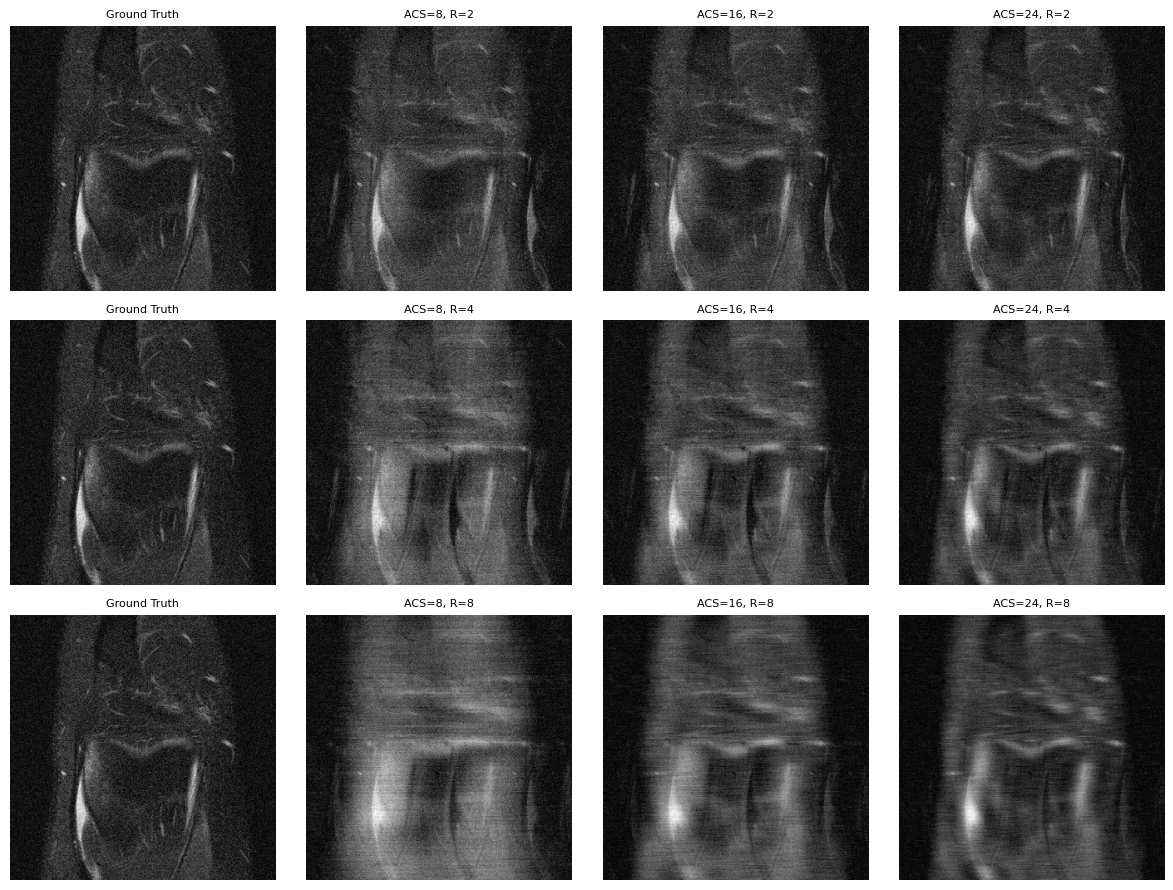

✅ Saved figure to cp2_mask_variation_grid.png


In [18]:
import matplotlib.pyplot as plt
import torch


def show_triplet_grid(dataset, idx=0, accels=(2,4,8), acs_list=(8,16,24), crop_hw=(320,320),
                      save_path="cp2_mask_variation_grid.png"):
    """
    Visualize ground truth and zero-filled reconstructions for multiple
    (accel, ACS) combinations in one grid.

    dataset: SingleCoilDataset (requires load_h5_file, ifft2c)
    idx:     slice index
    accels:  iterable of acceleration factors
    acs_list: iterable of ACS sizes
    crop_hw: (height, width) for center cropping
    save_path: file path to save figure
    """
    # --- Load single slice ---
    print('hello')
    filepath, slice_idx = dataset.filepath_slice_idxs[idx]
    ds = load_h5_file(filepath)
    ksp = ds['kspace'][slice_idx]

    # convert to complex if necessary
    if not torch.is_complex(ksp):
        # Uncomment if dataset stores last-dim [real, imag]
        # ksp = torch.view_as_complex(ksp)
        pass

    gt_full = to_mag(ifft2c(ksp))
    gt_full = center_crop(gt_full / gt_full.max().clamp_min(1e-8), *crop_hw)

    n_rows = len(accels)
    n_cols = len(acs_list) + 1  # +1 for ground truth column

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), squeeze=False)

    for r_i, R in enumerate(accels):
        # Leftmost column: GT
        axs[r_i, 0].imshow(gt_full.cpu(), cmap="gray")
        axs[r_i, 0].set_title("Ground Truth", fontsize=8)
        axs[r_i, 0].set_ylabel(f"R={R}", fontsize=8)
        axs[r_i, 0].axis("off")

        for a_i, acs in enumerate(acs_list):
            mask = EquispacedMasker(accel=R, acs=acs)(ksp.shape[-1])
            mask = mask.reshape(1, -1).expand(ksp.shape[-2], ksp.shape[-1])
            ksp_masked = ksp * mask
            img_zf = to_mag(ifft2c(ksp_masked))
            img_zf = center_crop(img_zf / img_zf.max().clamp_min(1e-8), *crop_hw)

            ax = axs[r_i, a_i + 1]
            ax.imshow(img_zf.cpu(), cmap="gray")
            ax.set_title(f"ACS={acs}, R={R}", fontsize=8)
            ax.axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved figure to {save_path}")


show_triplet_grid(train_set, idx=50, accels=(2,4,8), acs_list=(8,16,24))



In [ ]:
len(train_set)

7135